In [ ]:
### THIS IS JUST FOR A MORE PRACTICAL AND FANCY NOTEBOOK
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
##################################################

# Pygemmes, modules, models, concepts and aggregates

## Paul Valcke

### EJP internal workshop

The goal of this session is : 
1. pygemmes can run on your computer
2. You know what are the properties of `pgm` and `hub`, how they work
3. You know how to :
    * get the knowledge of what is available
    * load the model you want, with a preset if you want
    * modify parameters and conditions
    * run simulations
    * do deeper analysis
    * plot data
4. You can write your own model

## Before everything : Import

* **pygemmes** can be downloaded on https://github.com/DaluS/GEMMES (branch : devel). The repo is private you need to give me your github pseudo to get it. 
* your python must know where to load the library, either define your "GEMMES" folder as original path, or execute the line under it.

you will need the following library : numpy, scipy, matplotlib, pyvis 


In [ ]:
import sys 

# Install all dependencies
#!{sys.executable} -m pip install numpy scipy matplotlib pyvis 

# Change path as the folder adress you have put the library in 
path = "C:\\Users\\Paul Valcke\\Documents\\GitHub\\GEMMES" 
sys.path.insert(0, path)
import pygemmes as pgm

## What is Pygemmes ? 

A differential system solver with "extra steps" :
* library of models
* Easy model creation, modification, coupling, tweaking 
* Automatic space allocation, resolution order
* Model summary, representation...
* Plots, analysis of cycles, sensibility


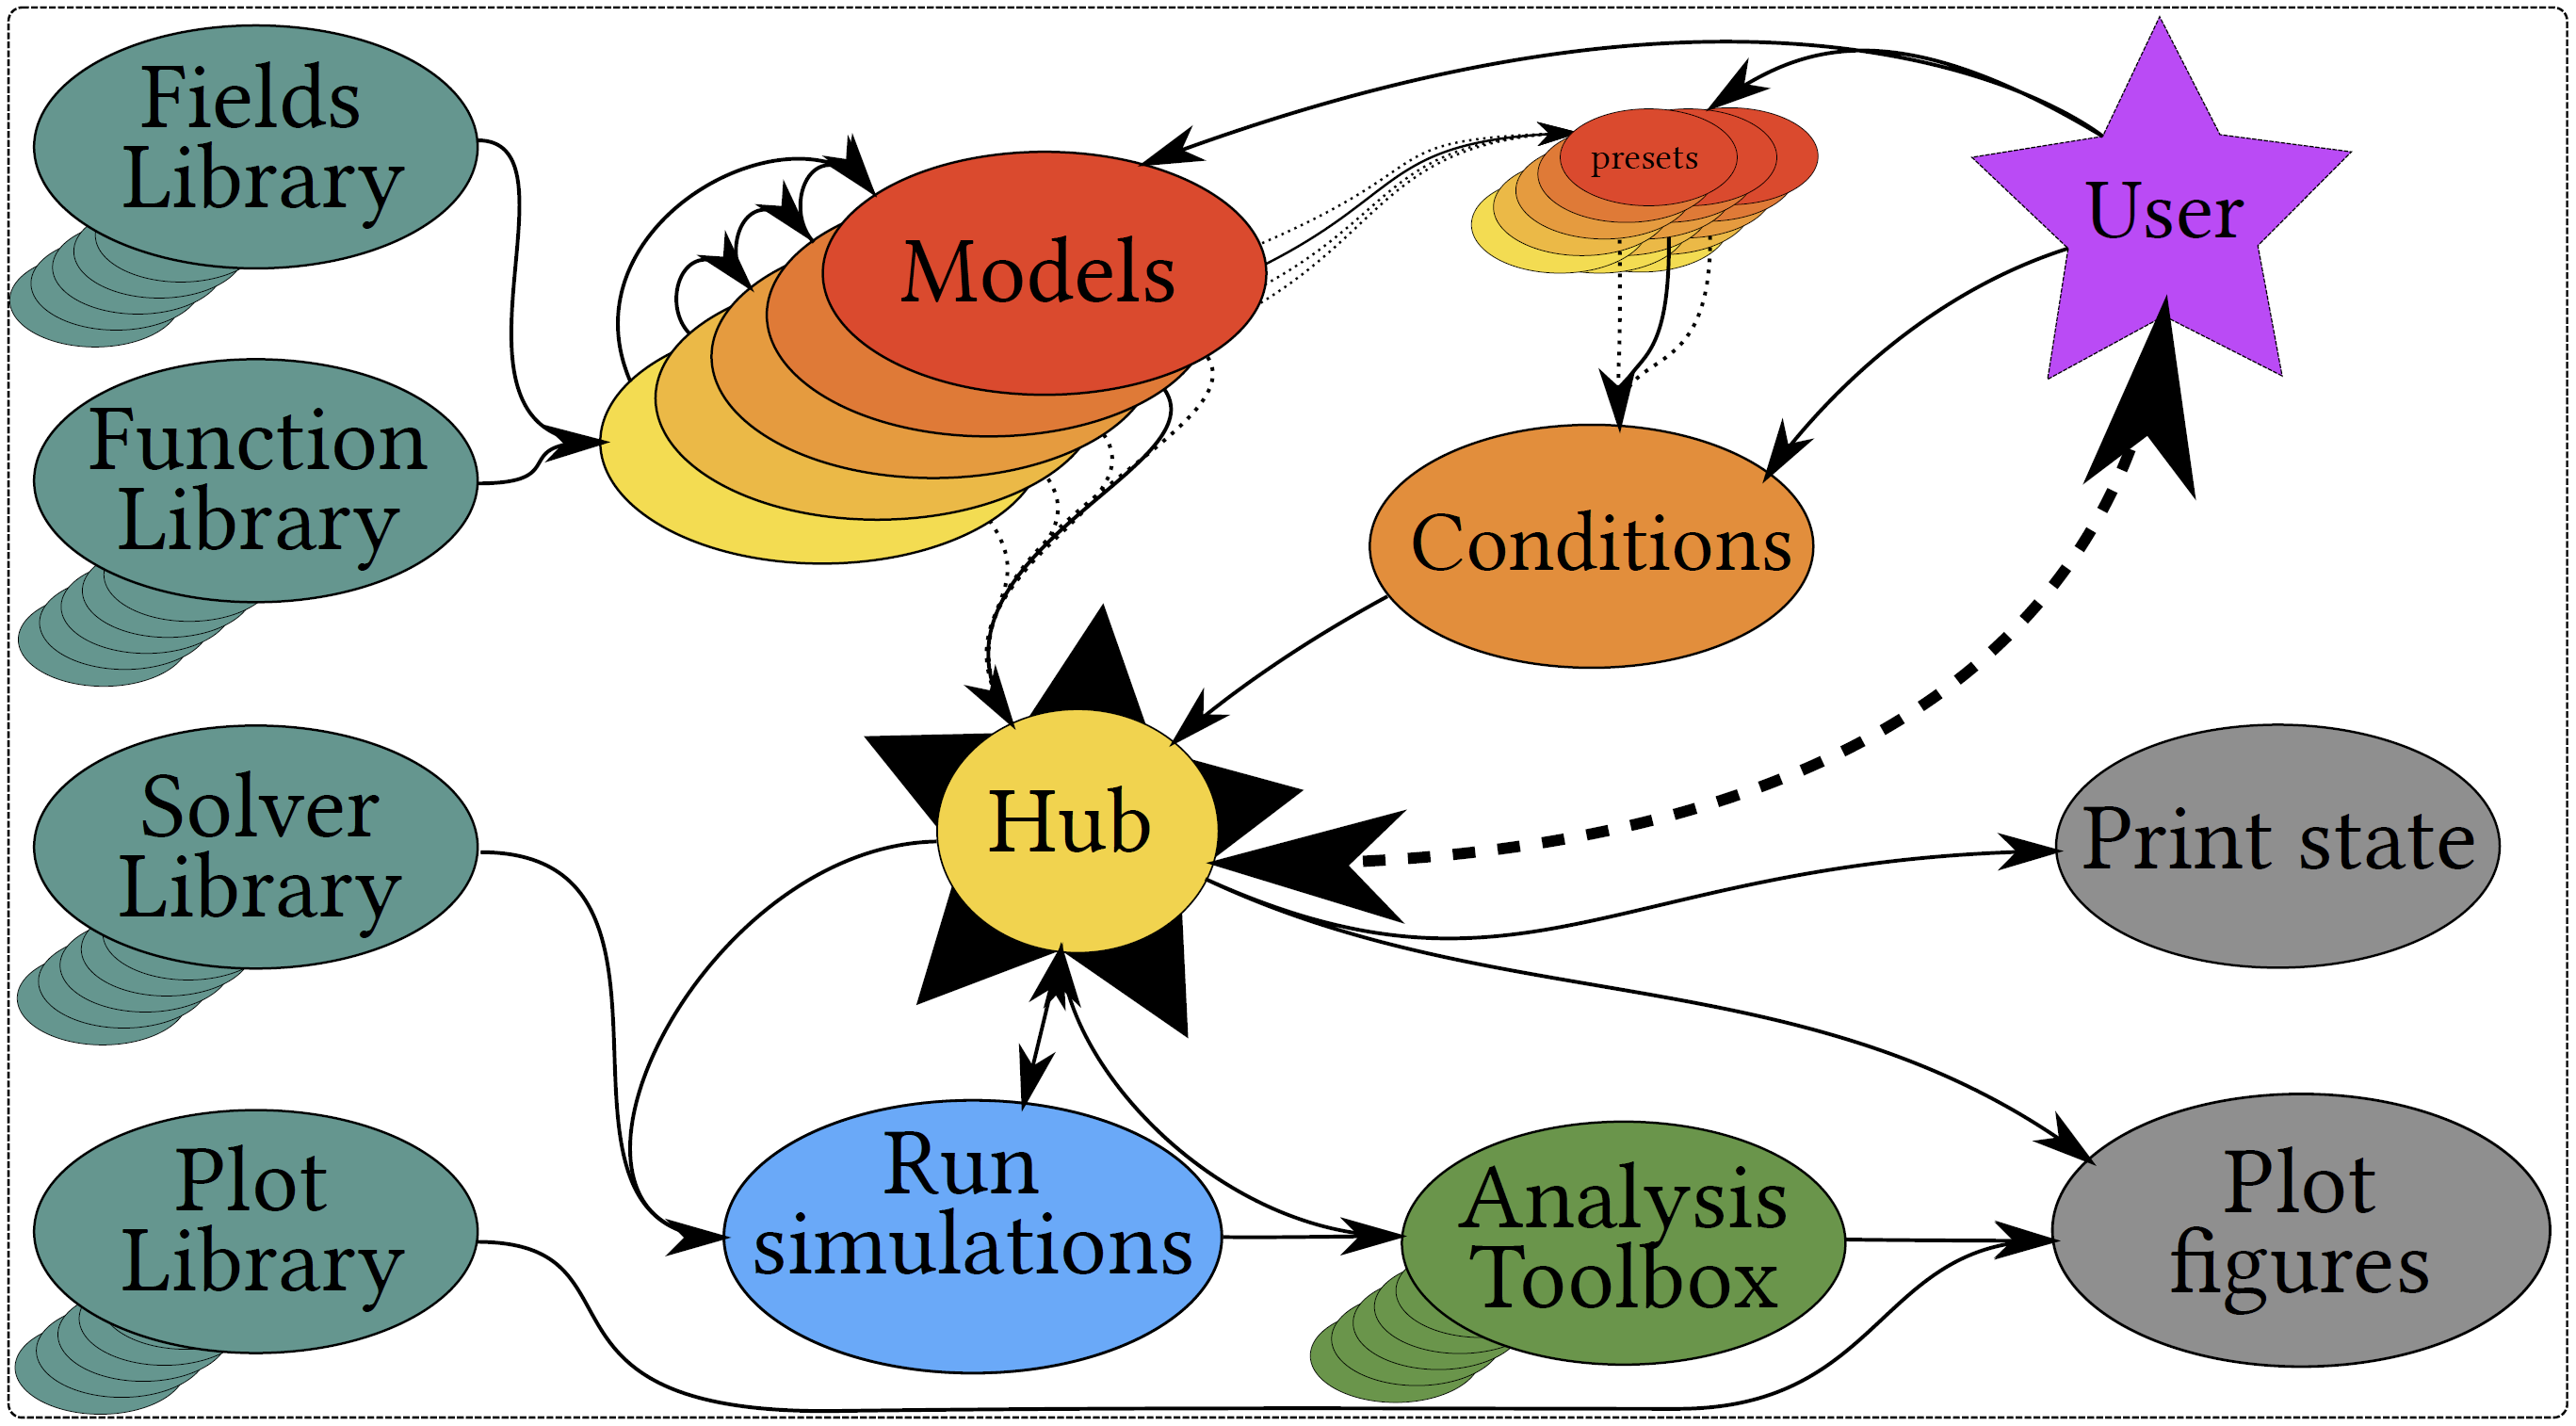

## pgm toolkit (before hub)

**ALWAYS USE TAB, AUTOINDENTATION, HELP( ), ? When exploring a library**

In [ ]:
help(pgm)

In [ ]:
### List of the methods and objects in the library 
for m in [f for f in dir(pgm) if f[0]!='_']: print(m)

## Map of the library
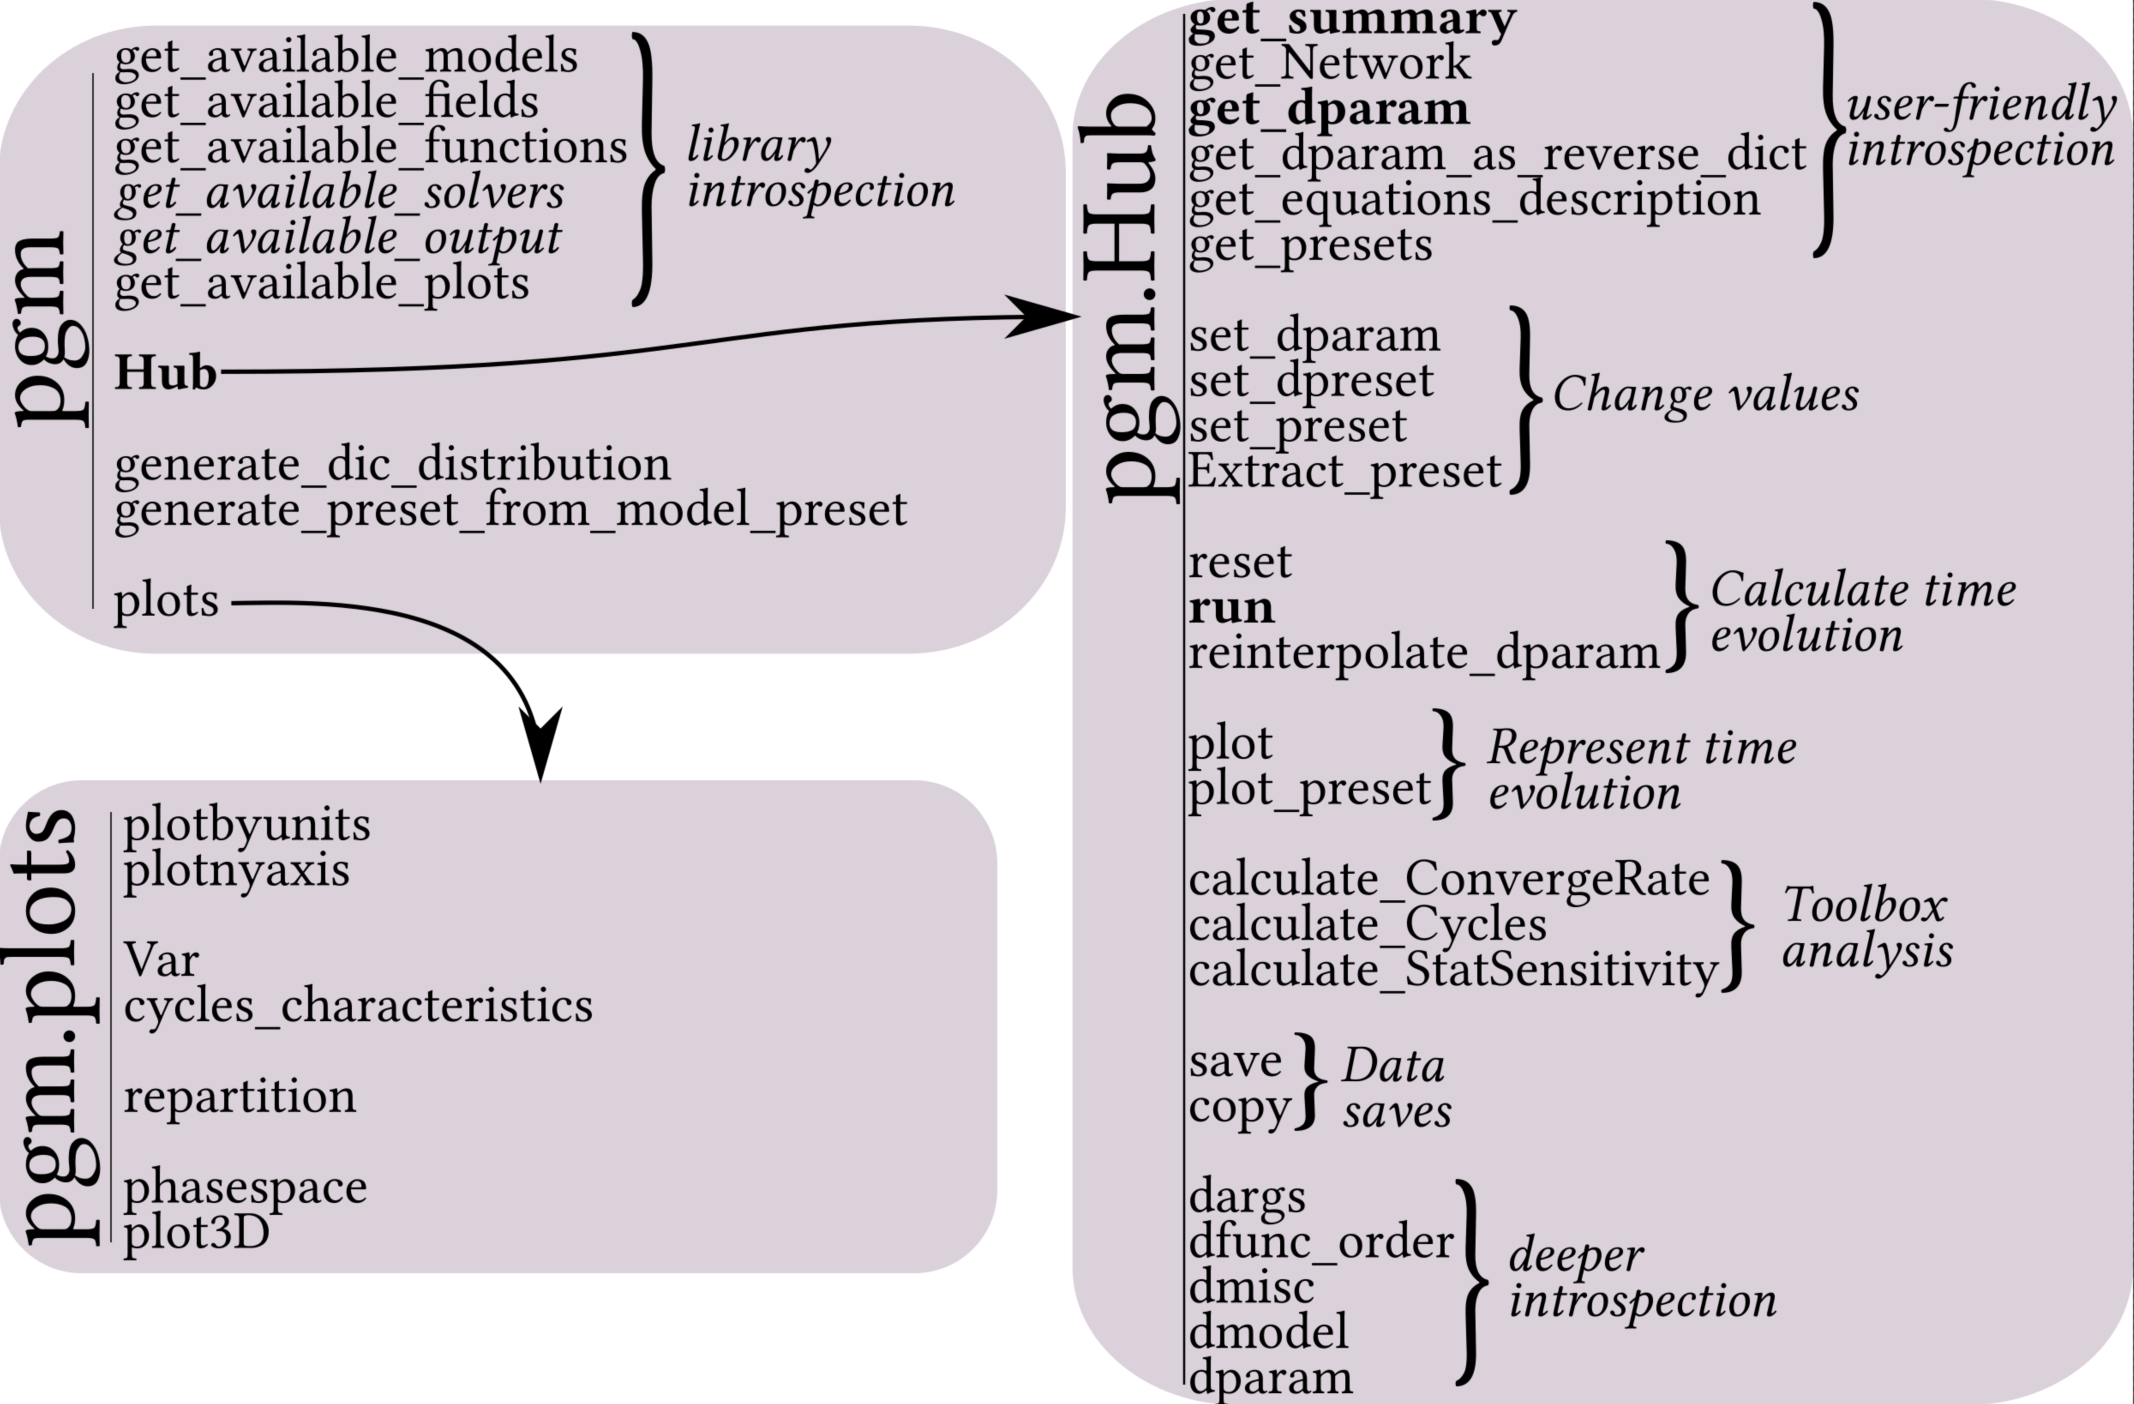

## The "get" methods
A lot of things are already coded in pygemmes so that you do not have to code them. There are multiple categories : 
* **Model files**, containing the endogenisation loops of your system (the equations), an ensemble of preset of values and associated plots
* **solvers**, to do temporal run of your set of equations 
* **fields**, an ensemble of definitions and basic value that can be shared through models (units, symbol, definitions, default values...) 
* **functions**, an ensemble of equations linking fields that can be called easily (a Philips curve, a population growth...)
* **plot**, an ensemble of custom-made plots that can be called easily for this architecture
* **output**, an ensemble of presaved runs (disactivated in 0.9)

### Get available models 
Those model are already coded, and have preset and plots associated to them ! 
You can use them directly to see what other modellers have done, 

In [ ]:
help(pgm.get_available_models)

In [ ]:
pgm.get_available_models(details=False)

In [ ]:
pgm.get_available_models('reduced_G',details=True)

In [ ]:
pgm.get_available_models(details=True)

## The other "get"

will be explained in due time
* get_available_fields
* get_available_functions
* get_available_output
* get_available_plots
* get_available_solvers

In [ ]:
pgm.get_available_solvers()

In [ ]:
pgm.get_available_output()

In [ ]:
pgm.get_available_functions()

In [ ]:
pgm.get_available_plots()

In [ ]:
pgm.get_available_fields()

## DOING THE REAL STUFF 

Now we will load a model, and see what we can do with it

The **MOST IMPORTANT** element of pygemmes is the **Hub**. You will call it with a model inside of it, then interact with the model through the Hub.

In [ ]:
help(pgm.Hub)

In [ ]:
modellist= pgm.get_available_models(details=False,returnas=list) 
print('Available models :\n')
modellist

A model is : 
* an ensemble of fields, quantities describing physical or informational values (temperature, employment)
* an equation associated to each of the field, determining its value over time, and how each fields are related to each others

there are three categories of possible equations : 
* **parameter :** the value is a constant (example, the gravitational constant, or the size of Mount Everest in a short-run simulation)
* **state variable :** the value is fully determined by every other fields ( the employment is determined by the quantity of workers and the population able to work, two other fields)
* **differential variables :** the variation of the value is a state variable : think about stock and flows : the variation of the stock is computed through the sum of the flow

It is possible that a same field is a parameter in some model (exogenous, constant), a state variable in other (instant adaptation), or a differential in others 

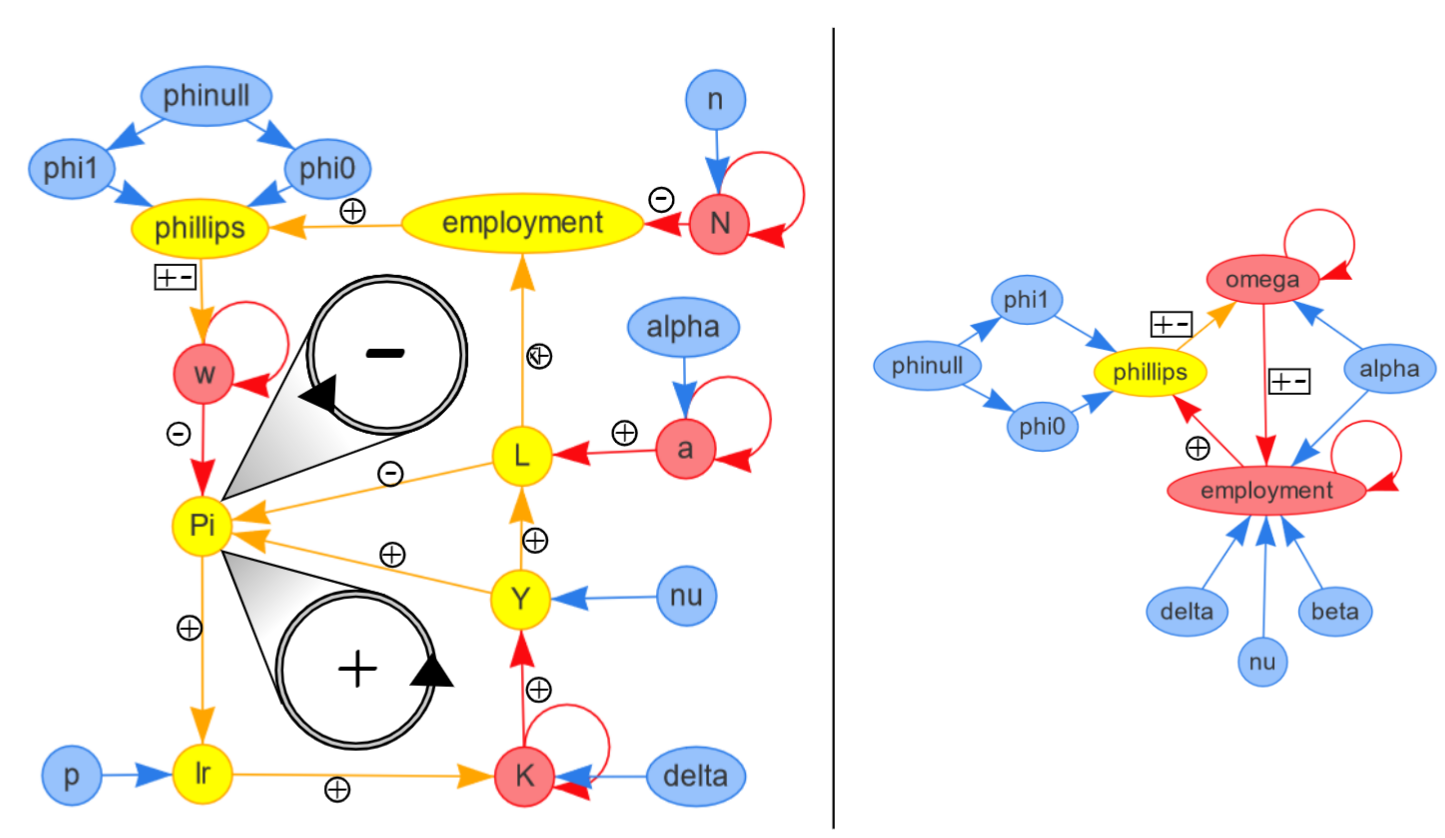

Here parameters are in blue, state variable yellow, differential variable in red. 
An simple criteria to know if it is an interesting model is "a model with loop in it, both positive and negative". 
On the left, the system is a Goodwin will its "extensive" equations, and on the right the dynamics on the phase-space. Both will solve the same overall thing

### What is the hub initialization doing ? 

* Find what are all the fields that exist in the system
* Determine if they are differential, state variable, parameters
* Try to find as many existing information as possible (typically in a file called `_def_fields`) that has not been put by the model creator but exist in a common database. It can be :
    * units 
    * symbol
    * definition 
    * default value
    * ...
* Find an order to calculate the system at each timestep, and what variables are necessary (in loops)
* Preparing allocation for future time calculation
* A bit of coffee

In [ ]:
hub=pgm.Hub('GK')

In [ ]:
hub.get_summary()  # definition concern the field definition, com the way it is calculated

In [ ]:
hub.get_equations_description()

In [ ]:
hub.get_Network()

In [ ]:
hub.get_Network(params=True)                    # state,differential,parameters
hub.get_Network(auxilliary=False,params=True)   # remove auxilliary statevar and differential
hub.get_Network(filters=('Pi',))                # remove the variable Pi and its connexions
hub.get_Network(filters=('Pi',),redirect=True)  # all connexions from Pi are reconnected

### Doing a run without changing values 
Once the initial state is well determined, you can let the system loop on itself

In [ ]:
help(hub.run)

In [ ]:
hub.run() # Will calculate 10 000 steps (100 year run) of a Goodwin-Keen system given the initial conditions

### The basic plot : temporal, grouped by units
for the moment we do not talk about region, idx, sectors, which are properties for more advanced systems !

In [ ]:
hub.plot()
help(hub.plot)

In [ ]:
hub.plot(filters_units=['',]) ### Only the dimensionless units
print(50*'#')
hub.plot(filters_units=('',)) ### Everything but the dimensionless units
print(50*'#')
hub.plot(filters_units=['','y'],
         filters_key=('kappa'),
         separate_variables={'':['employment','omega']},
         title='basic GK') ### Everything but the dimensionless units

### GET ACCESS TO DATA 
All data are in dparam of hub, as a dictionnary of (dictionnary of (dictionnary))
It could be transformed someday in pandas, if someone wants to do it (I have other things to do but that could be nice)

First layer : field name, 
second layer : field properties 

Same system of filters exist for `hub.get_dparam` with list and tuples

In [ ]:
help(hub.get_dparam)

In [ ]:
R1 = hub.get_dparam(key=['employment', 'omega'])
R2 = hub.get_dparam(key=('employment', 'omega'))
print(R1.keys(),'\n',R2.keys())

In [ ]:
R1['employment'].keys()

In [ ]:
groupsoffields = hub.get_dparam_as_reverse_dict(
    crit='units',
    eqtype=['differential', 'statevar'])
for k,v in groupsoffields.items():
    print(k.ljust(25),list(v.keys()))
    
print('\n\n WITH PARAMETERS')
groupsoffields = hub.get_dparam_as_reverse_dict(
    crit='units',
    eqtype=['differential', 'statevar',None])
for k,v in groupsoffields.items():
    print(k.ljust(25),list(v.keys()))

#### Technical point : the data shape

`Pygemmes` core is made to take into account complex problem, the maximum level for the moment is : 
* multiple system in parrallel with different parameters (not interacting but simulated in parrallel) : it allows statistical treatment on a high number of run, stochasticity, sensibility....
* multiple regions with the same description, interacting differently
* fields to be a vector (N sectors who has a different price)
* fields to be a matrix (coupling between sectors for example)

`Pygemmes` is mostly based on a numpy implementation, dealing well with complex problem of dimensions. By default, all the fields will have values as a 5-dimensional tensor as follow : 
* **a** 'nt' number of timesteps (parameters do not have this one)
* **b** 'nx' number of parrallel system
* **c** 'nr' number of regions
* **d** number of sectors or `__ONE__`
* **e** number of sectors or `__ONE__` 

In consequence, if you want the field `field` value at time iteration **a**, on parrallel system **b**, on region **c**, between sector **d** and **e**, you want 
`R[field]['value'][a,b,c,d,e]`
If you have a monosectoral system with only one region, one parrallel system, and you want all the time values :
`R[field]['value'][:,0,0,0,0]`

In [ ]:
## Example : 
import matplotlib.pyplot as plt 
import numpy as np
R=hub.get_dparam(key=['employment','time'])
print(np.shape(R['employment']['value']))
x=R['time']['value'][:,0,0,0,0]
y=R['employment']['value'][:,0,0,0,0]
plt.plot(x,y)
plt.xlabel('time')
plt.ylabel('employment $\lambda$')
plt.show()

### Access to plots already existing 
A lot of plot can be accessed, here is a few samples 

In [ ]:
plotlist = [f for f in dir(pgm.plots) if f[0]!= '_']
plotlist

In [ ]:
help(pgm.plots.Var)
pgm.plots.Var(hub,'K',log=True)
pgm.plots.Var(hub,'pi',mode='cycles') # We ask him for cycles information. He will activate a toolbox for you to get the data
# sensitivity will be shown later (section set_dparam)

In [ ]:
help(pgm.plots.phasespace)
pgm.plots.phasespace(hub,
                     x='employment',
                     y='omega',
                     color='d')

In [ ]:
help(pgm.plots.plot3D)
pgm.plots.plot3D(hub, x='employment',
                 y='omega',
                 z='d',
                 color='pi',
                 cmap='jet',
                 index=0,
                 title='')

In [ ]:
help(pgm.plots.plotbyunits)
pgm.plots.plotbyunits(hub) # same as hub.plot()


In [ ]:
help(pgm.plots.cycles_characteristics)
pgm.plots.cycles_characteristics(hub,'omega','employment',ref='pi',type1='stdval')

In [ ]:
help(pgm.plots.plotnyaxis)
pgm.plots.plotnyaxis(hub, x='time',
             y=[['employment', 'omega'],
                ['pi','kappa'],
                ['d'],
                ],
             idx=0,
             title='',
             lw=2)

In [ ]:
### THis is boring on a "too simple" model, but will be great on some more advanced stuff
help(pgm.plots.repartition)
pgm.plots.repartition(hub,['C','Ir'],ref='Y',sector='')

### Presets ! 

If the modeller is a nice guy, he created some preset to show some of the model special cases. They contains : 
* specific set of parameters and initial conditions
* plots to put the properties under the spotlight


In [ ]:
pgm.get_available_models()
pgm.get_available_models('GK',details=True)

There are multiple way to load a preset from the start : 
* hub=pgm.Hub('GK',preset=presetname)
* hub=pgm.Hub('GK');hub.set_preset(presetname)

In [ ]:
hub=pgm.Hub('GK',preset='default')
hub.run()
hub.plot_preset()

In [ ]:
hub=pgm.Hub('GK')
hub.set_preset('farfromEQ')
hub.run()
hub.plot_preset()

### THE INFAMOUS SET_DPARAM

Behold ! 
This is the magic function which allow you to change any initial value or parameter, either socio-physical or purely numerical

In [ ]:
help(hub.set_dparam)

In [ ]:
# changing one value 
hub=pgm.Hub('GK',verb=False)
hub.set_dparam('alpha',0)
hub.get_summary()

In [ ]:
# PUTTING 10 VALUES 
import numpy as np
hub=pgm.Hub('GK',verb=False)
hub.set_dparam(**{
    'nx':3,
    'alpha':np.linspace(0,0.1,3)})
hub.run()
pgm.plots.Var(hub,'employment',mode='sensitivity')

In [ ]:
# Putting values taken randomly in a distribution 
SensitivityDic = {
    'alpha': {'mu': .02,
              'sigma': .12,
              'type': 'log'},
    'k2': {'mu': 20,
           'sigma': .12,
           'type': 'log'},
    'mu': {'mu': 1.3,
           'sigma': .12,
           'type': 'log'},
}
presetSimple = pgm.generate_dic_distribution(
    {'alpha': {'mu': 0.02,
               'sigma': .2,
               'type': 'log'}, }, N=100)
presetCoupled = pgm.generate_dic_distribution(SensitivityDic,
                                              N=100)
presetCoupled['nx']=100

hub=pgm.Hub('GK',verb=False)
hub.set_dparam(**presetCoupled)
hub.run(N=1000)
hub.calculate_StatSensitivity()
pgm.plots.Var(hub,'employment',mode='sensitivity')

## Convergence rate and valleys of stability 
to be done later !

## Multisectorality 

The new cool kid in town

In [ ]:
pgm.get_available_models()
hub=pgm.Hub('CHIMES',preset='GoodwinPURE')
hub.get_summary()
hub.run()

In [ ]:
def allplots_multisect(hub):
    R=hub.get_dparam()
    sectors = R['Nprod']['list']
    for sector in sectors :
        pgm.plots.plotnyaxis(hub, y=[[['inflation', sector],
                                      ['inflationMarkup', sector],
                                      ['inflationdotV', sector], ],
                                     [['c',sector],
                                      ['p',sector]],
                                     [['pi',sector],
                                      ['kappa',sector]],
                                     [['employmentlocal',sector],
                                      ['u',sector],
                                      ]],)
        pgm.plots.repartition(hub,
                              ['pi','omega','xi','gamma','rd','reloverinvest','reldotv'],
                              sector=sector,
                              title='Expected relative budget $\pi$ ')
        pgm.plots.repartition(hub,['TakenbyY','TakenbyI','C','dotV'],
                              ref='Y',
                              sector=sector,
                              title=f'Physical Fluxes for sector {sector}')
        pgm.plots.repartition(hub,['Wage','TransactInter','TransactI','Consumption','Interests'],
                              ref='dotD',
                              sector=sector,
                              title=f'Monetary Fluxes for sector {sector}')
    

In [ ]:
hub=pgm.Hub('CHIMES',preset='Bi-sectoral')
hub.get_summary()
hub.run()


In [ ]:
hub.get_summary(removesector=('Consumption'))

In [ ]:
allplots_multisect(hub)

## Inter-region interactions

We can solve 
    $dC/dt = -D \nabla \nabla C$
With the spatial dimension being taken by distances



In [ ]:
pgm.get_available_models('Diffusion',details=True)
hub=pgm.Hub('Diffusion',preset='Basic')
hub.run()
R=hub.get_dparam()
C=R['C']['value'][:,0,:,0,0]
for i in range(9):
    plt.plot(C[100*i,:],label=f't={i}')
plt.legend()
plt.show()

hub.get_equations_description()

### RUN PERTURBATION

We run the system, then we take the final state of the system as the initial condition of a new one. We shift the value, and we see how it respond.

In [ ]:
### FIRST RUN
hub=pgm.Hub('GK',preset='default')
hub.set_dparam('dt',0.1)
hub.run()
hub.plot()

### WE EXTRACT THE NEW STATE OF THE SYSTEM 
newpreset=hub.Extract_preset()

### WE PUT IT IN A NEW HUB ( TO KEEP PREVIOUS VALUES )
hubnext=pgm.Hub('GK')
hubnext.set_dparam(**newpreset)
hubnext.set_dparam('K',200)
hubnext.run()
hubnext.plot()

# Your turn ! 

## Running the system on your own
1. Reset your terminal
2. Load pygemmes 
3. Load a model (GoodwinFull) 
4. Look at the summary 
5. Change one parameter (for example, the interest rate)
6. Do a run 
7. Do a plot of only variables you want (for example employment, omega, d,N,L)
8. Do a 3D plot 
9. Calculate the cycles and show them one omega
10. Change the interest rate with 15 different values, and check the sensitivity of the system to it on employment
11. Load a preset, and plot it

Bonus : define a set of things you would be interested to do with pygemmes, either do it or share it here : https://github.com/DaluS/GEMMES/discussions/192

Then you can switch on creating your own models, with the tutorial `Model creation` is the same folder as this one